In [70]:
import os, math
import numpy as np, pandas as pd
import matplotlib.pyplot as plt, seaborn as sns
from scipy.spatial.distance import pdist, squareform
from scipy.stats import mannwhitneyu
from statsmodels.stats.multitest import multipletests
from sklearn.decomposition import PCA

np.random.seed(2025)


In [71]:
# Load data
data_dir = "data"
ab_path = os.path.join(data_dir, "MetaCardis2020_relative_abundance.csv")
meta_path = os.path.join(data_dir, "MetaCardis2020_sample_metadata.csv")
taxa_meta_path = os.path.join(data_dir, "MetaCardis2020_taxa_metadata.csv")

RESULTS = os.path.join(data_dir, "results_EDA")
FIGS = os.path.join(RESULTS, "figures")
TABLES = os.path.join(RESULTS, "tables")
os.makedirs(FIGS, exist_ok=True); os.makedirs(TABLES, exist_ok=True)


In [72]:
ab_raw = pd.read_csv(ab_path, index_col=0)
meta = pd.read_csv(meta_path, index_col=0)
taxa_meta = pd.read_csv(taxa_meta_path, index_col=0)

print("ab_raw.shape (rows x cols):", ab_raw.shape)
print("meta.shape:", meta.shape)
print("taxa_meta.shape:", taxa_meta.shape)
display(ab_raw.head().T)   
display(meta.head())
display(taxa_meta.head())

ab_raw.shape (rows x cols): (697, 1831)
meta.shape: (1831, 25)
taxa_meta.shape: (697, 7)


taxa,Bacteroides uniformis,Phocaeicola dorei,Alistipes finegoldii,Phocaeicola vulgatus,Eubacterium sp. CAG:180
M0x10MCx1134,18.68909,10.88477,8.14016,7.69579,5.24825
M0x10MCx1135,0.47634,0.12509,0.11658,0.06780,5.09389
M0x10MCx1138,1.69175,19.99088,0.31639,1.37651,0.00000
M0x10MCx1140,8.54740,8.29615,0.00000,2.42549,0.00000
M0x10MCx1143,11.01829,28.54958,0.00000,0.00000,0.00000
...,...,...,...,...,...
M0x30MCx3384,1.09316,0.14840,0.00000,1.80244,2.05756
M0x30MCx3412,38.16991,4.62311,0.17234,5.02784,0.00000
M0x30MCx3414,0.90933,1.27721,0.73518,1.56852,3.94000
M0x30MCx3422,7.93352,1.23356,0.91919,3.94948,0.00000


,study_name,subject_id,body_site,antibiotics_current_use,study_condition,disease,age_category,gender,country,non_westernized,...,BMI,treatment,location,disease_subtype,triglycerides,hba1c,smoke,bristol_score,hsCRP,LDL
M0x10MCx1134,MetaCardis_2020_a,M0x10MCx1134,stool,no,IGT,IGT;MS,adult,female,FRA,no,...,44.365888,antihta;thiazidique;at2_inhib,Paris,NaN,97.940706,6.0,no,1.0,1.3,140.673726
M0x10MCx1135,MetaCardis_2020_a,M0x10MCx1135,stool,no,T2D,T2D,adult,male,FRA,no,...,27.719670,antidiab;su;metformin;dppiv;insulin,Paris,NaN,NaN,NaN,no,NaN,NaN,NaN
M0x10MCx1138,MetaCardis_2020_a,M0x10MCx1138,stool,yes,T2D,T2D,adult,male,FRA,no,...,38.221055,antidiab;su;metformin,Paris,NaN,NaN,NaN,1.0,NaN,NaN,NaN
M0x10MCx1140,MetaCardis_2020_a,M0x10MCx1140,stool,NaN,control,MS,adult,female,FRA,no,...,36.283006,antihta;thiazidique;at2_inhib;ca2_cbl,Paris,NaN,NaN,NaN,no,NaN,NaN,NaN
M0x10MCx1143,MetaCardis_2020_a,M0x10MCx1143,stool,yes,T2D,T2D,senior,female,FRA,no,...,39.817729,antihta;antidiab;thiazidique;at2_inhib;metformin,Paris,NaN,NaN,NaN,no,NaN,NaN,NaN


,superkingdom,phylum,class,order,family,genus,species
Bacteroides uniformis,Bacteria,Bacteroidota,Bacteroidia,Bacteroidales,Bacteroidaceae,Bacteroides,Bacteroides uniformis
Phocaeicola dorei,Bacteria,Bacteroidota,Bacteroidia,Bacteroidales,Bacteroidaceae,Phocaeicola,Phocaeicola dorei
Alistipes finegoldii,Bacteria,Bacteroidota,Bacteroidia,Bacteroidales,Rikenellaceae,Alistipes,Alistipes finegoldii
Phocaeicola vulgatus,Bacteria,Bacteroidota,Bacteroidia,Bacteroidales,Bacteroidaceae,Phocaeicola,Phocaeicola vulgatus
Eubacterium sp. CAG:180,Bacteria,Firmicutes,Clostridia,Eubacteriales,Eubacteriaceae,Eubacterium,Eubacterium sp. CAG:180


In [73]:
#transpose abundance and check alignment
ab = ab_raw.T.copy()   # now rows = samples, cols = taxa
print("ab (samples x taxa) shape:", ab.shape)

print("First 5 sample IDs in abundance:", list(ab.index[:5]))
print("First 5 sample IDs in metadata:", list(meta.index[:5]))

# how many sample IDs overlap between abundance and metadata?
common = ab.index.intersection(meta.index)
print(f"Common sample IDs: {len(common)} / {ab.shape[0]} (abundance) and {meta.shape[0]} (metadata)")

ab (samples x taxa) shape: (1831, 697)
First 5 sample IDs in abundance: ['M0x10MCx1134', 'M0x10MCx1135', 'M0x10MCx1138', 'M0x10MCx1140', 'M0x10MCx1143']
First 5 sample IDs in metadata: ['M0x10MCx1134', 'M0x10MCx1135', 'M0x10MCx1138', 'M0x10MCx1140', 'M0x10MCx1143']
Common sample IDs: 1831 / 1831 (abundance) and 1831 (metadata)


In [74]:
# show up to 5 example mismatches (if any)
ab_only = list(sorted(set(ab.index) - set(meta.index)))[:5]
meta_only = list(sorted(set(meta.index) - set(ab.index)))[:5]
print("Example sample IDs present in abundance but NOT in metadata:", ab_only)
print("Example sample IDs present in metadata but NOT in abundance:", meta_only)

Example sample IDs present in abundance but NOT in metadata: []
Example sample IDs present in metadata but NOT in abundance: []


In [75]:
#Check duplicates and missingness

# Check for duplicate sample IDs
dup_ab = ab.index[ab.index.duplicated()]
dup_meta = meta.index[meta.index.duplicated()]
print("Duplicate samples in abundance:", len(dup_ab))
print("Duplicate samples in metadata:", len(dup_meta))

# Check for missing values in metadata
missing_counts = meta.isna().sum().sort_values(ascending=False)
print("\nTop 10 metadata columns with missing values:")
print(missing_counts.head(10))

Duplicate samples in abundance: 0
Duplicate samples in metadata: 0

Top 10 metadata columns with missing values:
disease_subtype            1822
hsCRP                      1002
bristol_score               997
hba1c                       992
LDL                         990
triglycerides               987
smoke                       528
BMI                         521
gender                      514
antibiotics_current_use     104
dtype: int64


In [76]:
# Look at unique values in the disease/study_condition columns
print("Unique values in 'study_condition':", meta['study_condition'].unique()[:10])
print("Unique values in 'disease':", meta['disease'].unique()[:10])

Unique values in 'study_condition': ['IGT' 'T2D' 'control' 'CAD' 'HF']
Unique values in 'disease': ['IGT;MS' 'T2D' 'MS' 'CAD' 'CAD;T2D' 'HF;T2D' 'healthy' 'IGT' 'MA'
 'HF;CAD']


In [77]:
# create unified Healthy vs Disease label
def map_health(row):
    cond = str(row['study_condition']).lower()
    dis = str(row['disease']).lower()
    if ('control' in cond) or ('healthy' in dis):
        return 'Healthy'
    else:
        return 'Disease'

meta['health_status'] = meta.apply(map_health, axis=1)

# Check how many samples in each class
print("Health status counts:")
print(meta['health_status'].value_counts(dropna=False))

# Drop samples with no label (if any)
meta = meta.dropna(subset=['health_status'])
ab = ab.loc[meta.index]
print("After removing unlabeled samples -> samples:", ab.shape[0])

Health status counts:
health_status
Disease    1189
Healthy     642
Name: count, dtype: int64
After removing unlabeled samples -> samples: 1831


In [78]:
# Clean antibiotics and treatment columns

if 'antibiotics_current_use' in meta.columns:
    meta['antibiotics_current_use'] = (
        meta['antibiotics_current_use']
        .astype(str)
        .str.lower()
        .str.strip()
        .replace({'nan': np.nan})
    )

    # Standardize values
    def clean_antibiotic(x):
        if pd.isna(x):
            return 'unknown'
        elif x.startswith('y'):
            return 'yes'
        elif x.startswith('n'):
            return 'no'
        else:
            return 'unknown'

    meta['antibiotic_use'] = meta['antibiotics_current_use'].apply(clean_antibiotic)
else:
    # If the column doesn't exist, create an empty one
    meta['antibiotic_use'] = 'unknown'

print("Antibiotic use value counts:")
print(meta['antibiotic_use'].value_counts(dropna=False))

# Clean treatment information (string normalization)
if 'treatment' in meta.columns:
    meta['treatment'] = (
        meta['treatment']
        .astype(str)
        .str.lower()
        .str.strip()
        .replace({'nan': np.nan})
    )
else:
    meta['treatment'] = np.nan


print("\nMost common treatments:")
print(meta['treatment'].value_counts().head(10))


Antibiotic use value counts:
antibiotic_use
no         944
yes        783
unknown    104
Name: count, dtype: int64

Most common treatments:
treatment
no                                                       539
ppi                                                       32
antidiab;metformin                                        25
antihta;ace_inhib                                         24
antilipid;antihta;beta_blockers;statin;antithombo;asa     24
antihta;beta_blockers                                     21
antilipid;statin                                          20
antidiab;metformin;dppiv                                  18
antihta;at2_inhib                                         17
antilipid;statin;asa                                      15
Name: count, dtype: int64


In [79]:
import math

# How many samples in the dataset
n_samples = ab.shape[0]

# Count in how many samples each taxon appears (>0)
prevalence = (ab > 0).sum(axis=0)

n_samples
prevalence

taxa
Bacteroides uniformis             1756
Phocaeicola dorei                 1297
Alistipes finegoldii              1489
Phocaeicola vulgatus              1640
Eubacterium sp. CAG:180            688
                                  ... 
Mageeibacillus indolicus             1
Dialister micraerophilus             1
Tissierellia bacterium KA00581       1
Anaerococcus lactolyticus            1
Actinomyces naeslundii               1
Length: 697, dtype: int64

In [80]:
# Filter rare taxa (low prevalence)

# Choose a threshold (e.g. ≥5 % of samples)
min_samples = math.ceil(0.05 * n_samples)
keep_taxa = prevalence[prevalence >= min_samples].index
print(f"Keeping {len(keep_taxa)} taxa out of {ab.shape[1]} (≥5% prevalence)")

# Filter the abundance table
ab_filt = ab[keep_taxa].copy()
print("Filtered abundance shape:", ab_filt.shape)

# also make a 1% version to test sensitivity later
min_samples_1pct = math.ceil(0.01 * n_samples)
keep_taxa_1pct = prevalence[prevalence >= min_samples_1pct].index
ab_filt_1pct = ab[keep_taxa_1pct].copy()
print("1% version shape:", ab_filt_1pct.shape)


Keeping 228 taxa out of 697 (≥5% prevalence)
Filtered abundance shape: (1831, 228)
1% version shape: (1831, 362)


In [81]:
# Normalize filtered table to relative abundances (sum = 1 per sample)

# use 5 % filtered version for main analysis
ab_rel = ab_filt.div(ab_filt.sum(axis=1), axis=0).fillna(0)

# every sample should now sum ≈ 1
sample_sums = ab_rel.sum(axis=1)
print("Relative-abundance sample sums (min–max):", sample_sums.min(), "-", sample_sums.max())

# if any sample sums = 0 → drop it 
zero_sum = sample_sums[sample_sums == 0].index
if len(zero_sum) > 0:
    print("Dropping", len(zero_sum), "zero-sum samples")
    ab_rel = ab_rel.drop(index=zero_sum)
    meta = meta.loc[ab_rel.index]

print("Normalized abundance shape:", ab_rel.shape)

# Save normalized version
ab_rel.to_csv(os.path.join(TABLES, "abundance_filtered5pct_relative.csv"))


Relative-abundance sample sums (min–max): 0.9999999999999983 - 1.0000000000000013
Normalized abundance shape: (1831, 228)


In [82]:
# Define diversity functions
def shannon(p):
    p = p[p > 0]
    return -(p * np.log(p)).sum()

def simpson(p):
    return 1 - (p**2).sum()

# Compute metrics for each sample
alpha = pd.DataFrame(index=ab_rel.index)
alpha['richness'] = (ab_rel > 0).sum(axis=1)
alpha['shannon'] = ab_rel.apply(shannon, axis=1)
alpha['simpson'] = ab_rel.apply(simpson, axis=1)

# Merge key metadata (for plotting & stratification)
alpha = alpha.join(meta[['health_status', 'antibiotic_use', 'treatment']])
alpha.head()

,richness,shannon,simpson,health_status,antibiotic_use,treatment
M0x10MCx1134,82,3.104297,0.924690,Disease,no,antihta;thiazidique;at2_inhib
M0x10MCx1135,85,2.020964,0.649169,Disease,no,antidiab;su;metformin;dppiv;insulin
M0x10MCx1138,69,2.552936,0.844483,Disease,yes,antidiab;su;metformin
M0x10MCx1140,93,3.296407,0.944447,Healthy,unknown,antihta;thiazidique;at2_inhib;ca2_cbl
M0x10MCx1143,41,2.224257,0.835120,Disease,yes,antihta;antidiab;thiazidique;at2_inhib;metformin


In [83]:
# Visualize Shannon diversity by health status
plt.figure(figsize=(6,5))
sns.violinplot(x='health_status', y='shannon', data=alpha, inner=None, palette='Set2')
sns.boxplot(x='health_status', y='shannon', data=alpha, width=0.15, showcaps=True, boxprops={'zorder':2}, fliersize=2)
plt.title("Shannon Diversity: Healthy vs Disease")
plt.ylabel("Shannon Index")
plt.xlabel("")
plt.tight_layout()
plt.savefig(os.path.join(FIGS, "shannon_by_health_vs_disease.png"), dpi=300, bbox_inches='tight')
plt.show()


AttributeError: module 'seaborn' has no attribute 'violinplot'

<Figure size 600x500 with 0 Axes>

In [33]:
# Mann–Whitney U test for diversity difference
healthy = alpha.loc[alpha['health_status'] == 'Healthy', 'shannon']
disease = alpha.loc[alpha['health_status'] == 'Disease', 'shannon']

u_stat, p_val = mannwhitneyu(healthy, disease, alternative='two-sided')
print(f"Mann–Whitney test (Shannon, Healthy vs Disease): p = {p_val:.3e}, U = {u_stat}")
print(f"Healthy mean = {healthy.mean():.3f}, Disease mean = {disease.mean():.3f}")


Mann–Whitney test (Shannon, Healthy vs Disease): p = 5.175e-01, U = 388656.0
Healthy mean = 2.799, Disease mean = 2.796


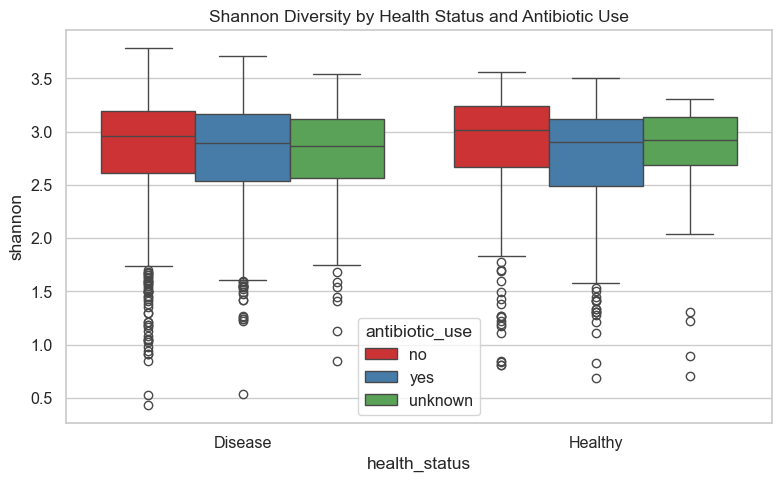

In [43]:
# Shannon diversity by health status & antibiotic use
plt.figure(figsize=(8,5))
sns.boxplot(x='health_status', y='shannon', hue='antibiotic_use', data=alpha, palette='Set1')
plt.title("Shannon Diversity by Health Status and Antibiotic Use")
plt.tight_layout()
plt.savefig(os.path.join(FIGS, "shannon_by_health_antibiotic.png"), dpi=300, bbox_inches='tight')
plt.show()


In [37]:
for abx in ['yes', 'no']:
    sub = alpha[alpha['antibiotic_use'] == abx]
    if len(sub['health_status'].unique()) == 2:
        h = sub.loc[sub['health_status'] == 'Healthy', 'shannon']
        d = sub.loc[sub['health_status'] == 'Disease', 'shannon']
        u, p = mannwhitneyu(h, d, alternative='two-sided')
        print(f"Antibiotic={abx}: p={p:.3e}, n_Healthy={len(h)}, n_Disease={len(d)}")


Antibiotic=yes: p=4.450e-01, n_Healthy=297, n_Disease=486
Antibiotic=no: p=7.373e-02, n_Healthy=319, n_Disease=625


In [39]:
# Does antibiotic use itself reduce Shannon diversity?
yes_abx = alpha.loc[alpha['antibiotic_use'] == 'yes', 'shannon']
no_abx = alpha.loc[alpha['antibiotic_use'] == 'no', 'shannon']

u_abx, p_abx = mannwhitneyu(yes_abx, no_abx, alternative='two-sided')
print(f"Antibiotic (yes vs no): p={p_abx:.3e}, mean yes={yes_abx.mean():.3f}, mean no={no_abx.mean():.3f}")


Antibiotic (yes vs no): p=4.366e-04, mean yes=2.775, mean no=2.825


In [41]:
alpha.to_csv(os.path.join(TABLES, "alpha_diversity.csv"))